# Simplified Machine Learning Workflow for Calculating the Odds of an EPL Football Match

The following is a simplified workflow to demonstrate the validity of using machine learning to calculate English Premier League (EPL) match odds. It is a proof of concept that would need to be built upon.

This is a simplification in that:
1. Not much effort has been put into collecting data to train the model with. Rather, a readily accessible database has been used. More data with more match statistics would likely improve model results.
2. The broader machine learning process involves experimenting with different model types/ combinations and varied model parameters to try and establish which is most reliable in its predictions.


A more comprehensive machine learning workflow would involve:
1. Comparing the suitabilities of various machine learning models (the random forest algorithm used here, however, is suitable)) to our specific problem
2. Sourcing more data. Suggestions are: players in the game, winning/ losing streak, historical possession statistics etc.

Crucially, the accuracy of the predictions are likely to improve if more data and data items (match statistics) are used to train the model.

### Section Outline

1. Scraping, importing, cleaning, and modifying data
2. Training the machine learning model
3. Example future prediction
4. Further work

## 1. Importing, cleaning, and modifying data.

Scrape the present season's match data.

This datasource is updated after every EPL match. It is therefore necessary to run this everytime before training a model to have the most recent match data.

The following comma-separated values (CSV) data has been imported from https://www.football-data.co.uk/englandm.php. I scraped data on the EPL season 2023-2024.

In [2]:
import requests

url = 'https://www.football-data.co.uk/mmz4281/2324/E0.csv'
file_name = 'data/E0.csv'

response = requests.get(url)

if response.status_code == 200:
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'File downloaded successfully as {file_name}')
else:
    print(f'Failed to download the file. Status code: {response.status_code}')

File downloaded successfully as data/E0.csv


Importing model dependencies

In [3]:
import pandas as pd

import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Import the data

In [4]:
df = pd.read_csv('data/E0.csv')

Viewing the first five rows

In [8]:
df.tail()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST
342,E0,27/04/2024,20:00,Aston Villa,Chelsea,2,2,D,2,0,H,C Pawson,9,21,4,5
343,E0,28/04/2024,14:00,Bournemouth,Brighton,3,0,H,1,0,H,P Tierney,15,13,6,1
344,E0,28/04/2024,14:00,Tottenham,Arsenal,2,3,A,0,3,A,M Oliver,14,9,2,3
345,E0,28/04/2024,16:30,Nott'm Forest,Man City,0,2,A,0,1,A,S Hooper,14,11,2,5
346,E0,02/05/2024,19:30,Chelsea,Tottenham,2,0,H,1,0,H,R Jones,16,19,5,3


I will limit the model to make use of the following columns only:

1. FTHG: Full Time Home Team Goals2. 
FTAG: Full Time Away Team Goal

3. FTR: Full Time Result (W = Home Win, D = Draw, L = Away Win)
4. 
HTHG: Half Time Home Team Goals
5. 
HTAG: Half Time Away Team Goa

6. HTR: Half Time Result (W = Home Win, D = Draw, L = Away Win)

7. Referee: Name of the referee who officiated the match
8. HS: Home Team Shots
9. AS: Away Team Shots
10. HST: Home Team Shots on Target
11. AST: Away Team Shots on Target on Targetts on Target

Removing the rest of the columns

In [9]:
# drop columns from fouls onwards: df.columns[16] = 'HF" (home fouls)

while len(df.columns) > 16:
    df.drop(df.columns[-1], axis=1, inplace=True)

In [10]:
df.tail()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST
342,E0,27/04/2024,20:00,Aston Villa,Chelsea,2,2,D,2,0,H,C Pawson,9,21,4,5
343,E0,28/04/2024,14:00,Bournemouth,Brighton,3,0,H,1,0,H,P Tierney,15,13,6,1
344,E0,28/04/2024,14:00,Tottenham,Arsenal,2,3,A,0,3,A,M Oliver,14,9,2,3
345,E0,28/04/2024,16:30,Nott'm Forest,Man City,0,2,A,0,1,A,S Hooper,14,11,2,5
346,E0,02/05/2024,19:30,Chelsea,Tottenham,2,0,H,1,0,H,R Jones,16,19,5,3


Drop/ remove unneccesary column

In [11]:
df.drop(['Div'], axis=1, inplace=True)

View the data types of the remaining columns

In [12]:
df.dtypes

Date        object
Time        object
HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG         int64
FTR         object
HTHG         int64
HTAG         int64
HTR         object
Referee     object
HS           int64
AS           int64
HST          int64
AST          int64
dtype: object

Machine leaning models can only work with numerical data. We will have to convert the non-integer columns above to integer equivalents and then capture these columns as predictor variables.

Give every team some integer code to be referenced by in the ML model, instead of a name.

In [13]:
df['opp_code'] = df['AwayTeam'].astype('category').cat.codes

Notice the new column

In [15]:
df.tail()

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,opp_code
342,27/04/2024,20:00,Aston Villa,Chelsea,2,2,D,2,0,H,C Pawson,9,21,4,5,6
343,28/04/2024,14:00,Bournemouth,Brighton,3,0,H,1,0,H,P Tierney,15,13,6,1,4
344,28/04/2024,14:00,Tottenham,Arsenal,2,3,A,0,3,A,M Oliver,14,9,2,3,0
345,28/04/2024,16:30,Nott'm Forest,Man City,0,2,A,0,1,A,S Hooper,14,11,2,5,12
346,02/05/2024,19:30,Chelsea,Tottenham,2,0,H,1,0,H,R Jones,16,19,5,3,17


The referee name, half-time result, and full-time result can also be number-coded for use in the ML model. The time the match is played might also have a bearing on teams' performace. We will capture only the hour.

In [16]:
df['referee_code'] = df['Referee'].astype('category').cat.codes

In [17]:
df['HTR_int'] = df['HTR'].map({"H": 1, "D": 0, "A": -1})

In [18]:
df['target'] = df["FTR"].map({"H": 1, "D": 0, "A": -1})

Notice that a home win is encoded as 1, a draw as 0, and a loss as -1.

In [19]:
df['hour'] = df['Time'].str.replace(':.+', '', regex=True).astype(int)

In [20]:
df.tail()

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,opp_code,referee_code,HTR_int,target,hour
342,27/04/2024,20:00,Aston Villa,Chelsea,2,2,D,2,0,H,C Pawson,9,21,4,5,6,3,1,0,20
343,28/04/2024,14:00,Bournemouth,Brighton,3,0,H,1,0,H,P Tierney,15,13,6,1,4,15,1,1,14
344,28/04/2024,14:00,Tottenham,Arsenal,2,3,A,0,3,A,M Oliver,14,9,2,3,0,12,-1,-1,14
345,28/04/2024,16:30,Nott'm Forest,Man City,0,2,A,0,1,A,S Hooper,14,11,2,5,12,22,-1,-1,16
346,02/05/2024,19:30,Chelsea,Tottenham,2,0,H,1,0,H,R Jones,16,19,5,3,17,16,1,1,19


## 2. Training the machine learning model

The random forests algorithm is suitable to use since:
1. Handles complex data: Football match data can be complex, with multiple factors influencing the outcome. Random Forests can effectively handle this complexity by combining multiple decision trees.2. Robust to irrelevant features: Random Forests are less sensitive to irrelevant features in the data, which might be present in football statistics.
3. Accuracy: Random Forests are known to achieve good accuracy in match prediction tasks.

To create an instance of random forests

In [262]:
rf = RandomForestClassifier(n_estimators=10, min_samples_split=5, random_state=1)

We have to split all our data into training and testing sets. Majority is put into the training set, which is where the model learns to predict from, while the rest is used to test the prediction accuracy of the trained model.

The datasource has 330 rows. We'll use 70% of it to train and 30% to test.

In [263]:
train = df[ : int(0.7*len(df))]
test = df[int(0.7*len(df)) : ]

Test data appearing in the training data is known to result in overfitting of a model (situation where the model is too conditioned to the training data and poorly generalizes to new data). To show that there is not overlap in the two sets, we view the end of the training set and the beginning of the test set.

In [264]:
# to show no overlap

train.tail(2)

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,opp_code,referee_code,HTR_int,target,hour
228,10/02/2024,12:30,Man City,Everton,2,0,H,0,0,D,J Brooks,19,5,3,1,8,9,0,1,12
229,10/02/2024,15:00,Fulham,Bournemouth,3,1,H,2,0,H,D England,7,25,6,4,2,7,1,1,15


In [265]:
test.tail(2)

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,opp_code,referee_code,HTR_int,target,hour
230,10/02/2024,15:00,Liverpool,Burnley,3,1,H,1,1,D,T Robinson,25,9,10,4,5,27,0,1,15
231,10/02/2024,15:00,Luton,Sheffield United,1,3,A,0,2,A,C Kavanagh,20,7,5,3,16,2,-1,-1,15


The indices show there is no overlap.

Below are all the columns in the datasource

In [266]:
df.columns

Index(['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'opp_code',
       'referee_code', 'HTR_int', 'target', 'hour'],
      dtype='object')

Only the following will be used for prediction

In [267]:
predictors = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'opp_code', 'hour', 'referee_code', 'HTR_int']

To assert that all predictor columns have numerical data type

In [268]:
for col in predictors:
    print(type(df[col][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int64'>


To fit/ train the random forests model

In [269]:
rf.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_split=5, n_estimators=10, random_state=1)

The model is now trained, meaning it can form predictions as long as it is given the predictors above.

Now to make predictions from our test data:

In [270]:
preds = rf.predict(test[predictors])

The predictions look like this

In [271]:
preds

array([ 1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1, -1,  0, -1, -1,
        0,  1,  1,  1,  0,  1, -1, -1,  1,  1,  1,  0, -1,  1,  1,  0,  1,
       -1, -1,  1, -1,  1,  0,  0,  1,  1, -1,  1,  0,  0,  1, -1,  1,  0,
        1,  0, -1,  1,  1,  0,  0,  1,  1,  0,  1, -1,  0,  1,  1,  0,  0,
        1,  0,  1,  1,  0, -1, -1,  1, -1,  1, -1, -1,  0,  0,  1,  1,  1,
        0,  1,  1,  0, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1],
      dtype=int64)

We would have to match each match in the testing set to the corresponding prediction above to make sense of these results.

Now, our test data already had the match results (it is historical data). We can compare our predictions with the actual results and work out the accuracy of our model as follows.

In [272]:
acc = accuracy_score(test['target'], preds)

In [273]:
acc

0.92

The model has about 92% accuracy. Again, the accuracy is likely to improve if more data is used in training, more parameters (columns) are used, and different (combinations of) machine learning algorithms are used.

## 3. Example future prediction

Testing the prediction for this weekend's (5pm 27th April, 2024) match between Manchester United and Burnley:

Let the home team be Man. U. and the away team be Burnley. We'll calculate the odds for the following match results: Date=27/04/2024, Time=17:00, FTHG=2, FTAG=1, FTR=H, HTHG=1, HTAG=1, HTR=H, Referee=M Atkinson, HS=30, AS=20, HST=14, AST=8.

This would be presented as "odds for Man. U. vs. Burnley, 27th April, 2024. Full time result: 2:1, Half time result: 1:1."

Odds for other probable outcomes would also be calculated and presented for purchase.

To find the opponent codes assigned to these two teams and the referee

In [274]:
df.groupby('AwayTeam')['opp_code'].first()

AwayTeam
Arsenal              0
Aston Villa          1
Bournemouth          2
Brentford            3
Brighton             4
Burnley              5
Chelsea              6
Crystal Palace       7
Everton              8
Fulham               9
Liverpool           10
Luton               11
Man City            12
Man United          13
Newcastle           14
Nott'm Forest       15
Sheffield United    16
Tottenham           17
West Ham            18
Wolves              19
Name: opp_code, dtype: int8

Burnley has an opp code of 4.

In [275]:
df.groupby('Referee')['referee_code'].first()

Referee
A Madley         0
A Taylor         1
C Kavanagh       2
C Pawson         3
C Salisbury      4
D Bond           5
D Coote          6
D England        7
G Scott          8
J Brooks         9
J Gillett       10
J Smith         11
L Smith         12
M Oliver        13
M Salisbury     14
P Bankes        15
P Tierney       16
R Jones         17
R Madley        18
R Welch         19
S Allison       20
S Attwell       21
S Barrott       22
S Hooper        23
S Singh         24
T Bramall       25
T Harrington    26
T Robinson      27
Name: referee_code, dtype: int8

M Atkinson has referee code 12.

Now putting this data into a form that can be passed into the random forests predictor model

In [276]:
manu_burn_27th = pd.DataFrame({
    'FTHG': [2],
    'FTAG': [1],
    'HTHG': [1],
    'HTAG': [1],
    'HS': [20],
    'AS': [14],
    'HST': [10],
    'AST': [8],
    'opp_code': [4],
    'hour': [17],
    'referee_code': [12],
    'HTR_int': [1]
})

In [277]:
manu_burn_27th

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,opp_code,hour,referee_code,HTR_int
0,2,1,1,1,20,14,10,8,4,17,12,1


To calculate the match prediction

In [278]:
preds_manu_burn_27th = rf.predict(manu_burn_27th)

In [279]:
preds_manu_burn_27th[0]

1

1 corresponds to W.

The prediction is that Man. U. will win.

To calculate the odds, we use the formula: odds = 1/probability. The probabilities for the three outcomes: draw, loss, win are:

In [280]:
p_outcomes = rf.predict_proba(manu_burn_27th)[0]
p_outcomes

array([0.04, 0.26, 0.7 ])

This is intepreted as a 70% probability of a Man. U. win, 26% probability of a draw, and a 4% probability of a Burnley win.

Compare this with Google's predictions of 65%, 19%, and 16% as below.

The fact that our model has been trained on only 330 data items for the present season only yet has predictions comparable to those of broader models speaks to the suitability of this approach.

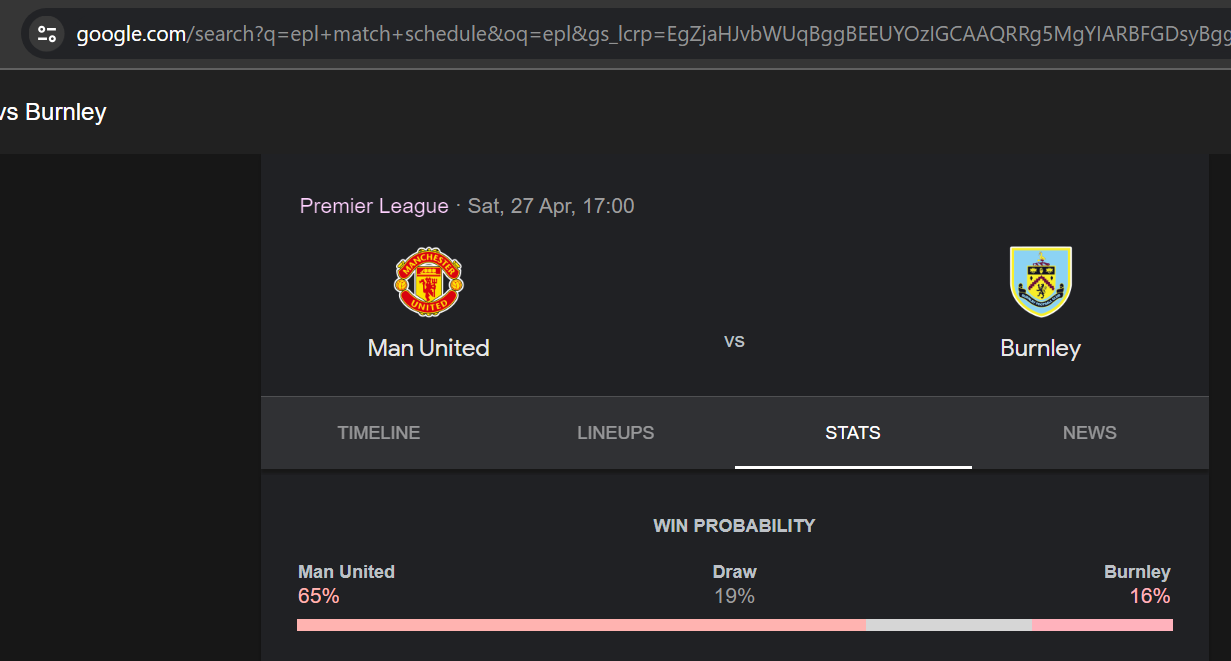

In [283]:
outcomes = ['loss', 'draw', 'win']
n = 0

for outcome in p_outcomes:
    print(f'The odds of {outcomes[n]} is {1/outcome}')
    n += 1

The odds of loss is 25.0
The odds of draw is 3.846153846153846
The odds of win is 1.4285714285714286


The odds of a loss are 25, those of a draw are 3.8, and those of a win are 1.4. Typically, the more extreme values (like the 25) would be regularized down using a statistical strategy the betting firm has worked out to ensure its long-term profit.

## 4. Further work

To improve model performance, get more data with more features.

Explore the accuracy of other machine learning models and techniques.

Develop an automated routine to get data on upcoming matches and work out the odds.